In [2]:
from lifelines import KaplanMeierFitter, CoxPHFitter
import statsmodels.api as sm
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as c
import numpy as np
import math
import json
sns.set(rc={'figure.figsize':(10,10)})


# 1. Import data for survival analysis + preprocessing

In [3]:
# mortality info, metadata for covariates, and brainAge predictions
mort_data = pd.read_csv("LLS_IOP3-MortalityData2024_20240412.csv") 
meta_data = pd.read_csv("/exports/molepi/SASC/ncdc/LLS_NCDC_data.csv", usecols = ["IOP2_ID", 'metabo_age', 'metabo_health', 'BMI', "Opleidingsniveau", 'Diabetes_Mellitus', 'Date_MRI', "Age", "Birth_year"])
with open("/exports/molepi/SASC/ncdc/lls_brain_age_mr_0506.json") as f:
    ba_vals = json.load(f)

In [9]:
# create final survival analysis df
surv_df = mort_data[["IOP2_ID"]]

# create an event column with only 0's (alive) and 1's (dead) for the newer mortality data
surv_df['mort'] =  np.array(["alive" not in mort for mort in mort_data['death2024'].values]).astype(int)

# map male/female to 0/1, respectively
surv_df['Sex'] = np.array([1 if row == "Female" else 0 for row in mort_data['Sex'].values]).astype(int)

# add other metadata + metaboAge from other file
surv_df = pd.merge(surv_df, meta_data, on='IOP2_ID')


# mapping the brainage values to the df
surv_df['ba'] = np.nan
for key in ba_vals.keys():
       surv_df.loc[surv_df['IOP2_ID'] == int(key), 'ba'] = ba_vals[key]
        
# create event date (either date of death, or censor date)
surv_df['event_date'] = mort_data['Dateofdeath'].combine_first(mort_data['referencedate'])
surv_df['event_time'] = (pd.to_datetime(surv_df['event_date']) - pd.to_datetime(surv_df['Date_MRI']))

# create metabo/brain age deltas
surv_df['delta_ba'] = surv_df['ba']  - surv_df['Age']
surv_df['delta_ma'] = surv_df['metabo_age'] - surv_df['Age']

# convert education value
def convert_education(value):
    if value == np.nan:
        return np.nan
    elif value < 5:
        return 0
    elif value < 7:
        return 1
    else:
        return 2
    
#convert education categories
surv_df['education_category'] = surv_df['Opleidingsniveau'].apply(lambda x : convert_education(x))

# drop NaNs
surv_df = surv_df.dropna(subset = ['metabo_age','ba', "Diabetes_Mellitus", "BMI"])

# convert event time to days
surv_df['event_time'] = surv_df['event_time'].dt.days

# renaming for plotting purposes
surv_df['MAG'] = surv_df['delta_ma']
surv_df['BAG'] = surv_df['delta_ba']

# create a followuptime dataframe
fu_time = surv_df.merge(mort_data[['IOP2_ID', 'fu_time_IOP3']], on = 'IOP2_ID')

# also create a timescale in years
surv_df['event_time_years'] = surv_df['event_time'] / 365.25

/tmp/ipykernel_156128/7645947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surv_df['mort'] =  np.array(["alive" not in mort for mort in mort_data['death2024'].values]).astype(int)
/tmp/ipykernel_156128/7645947.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surv_df['Sex'] = np.array([1 if row == "Female" else 0 for row in mort_data['Sex'].values]).astype(int)


# 2. Including only age as covariate
## Predict mortality

In [12]:
# create + fit cox ph model
coxph = CoxPHFitter()
surv_df['\u0394 brainAge'] = surv_df['delta_ba']
surv_df['\u0394 metaboAge'] = surv_df['delta_ma']
cox_ageOnly = coxph.fit(surv_df[['event_time_years', 'mort', 'Age', 'BAG', 'MAG']], 'event_time_years', 'mort')
cox_ageOnly.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
Age,0.233260,0.039155,2.562518e-09
BAG,0.083029,0.037323,2.610750e-02
MAG,0.034153,0.024084,1.561720e-01


In [13]:
# look at 1st and 3rd quantiles
print(np.quantile(surv_df['delta_ma'],[0.25,0.75]))
print(np.quantile(surv_df['delta_ba'],[0.25,0.75]))


[-4.2897232   5.84873482]
[-6.62039421  0.57884891]


/tmp/ipykernel_156128/170437756.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1=plt.subplot(121)


Text(0.5, 1.0, 'survival curves, Age-adjusted model, LLS')

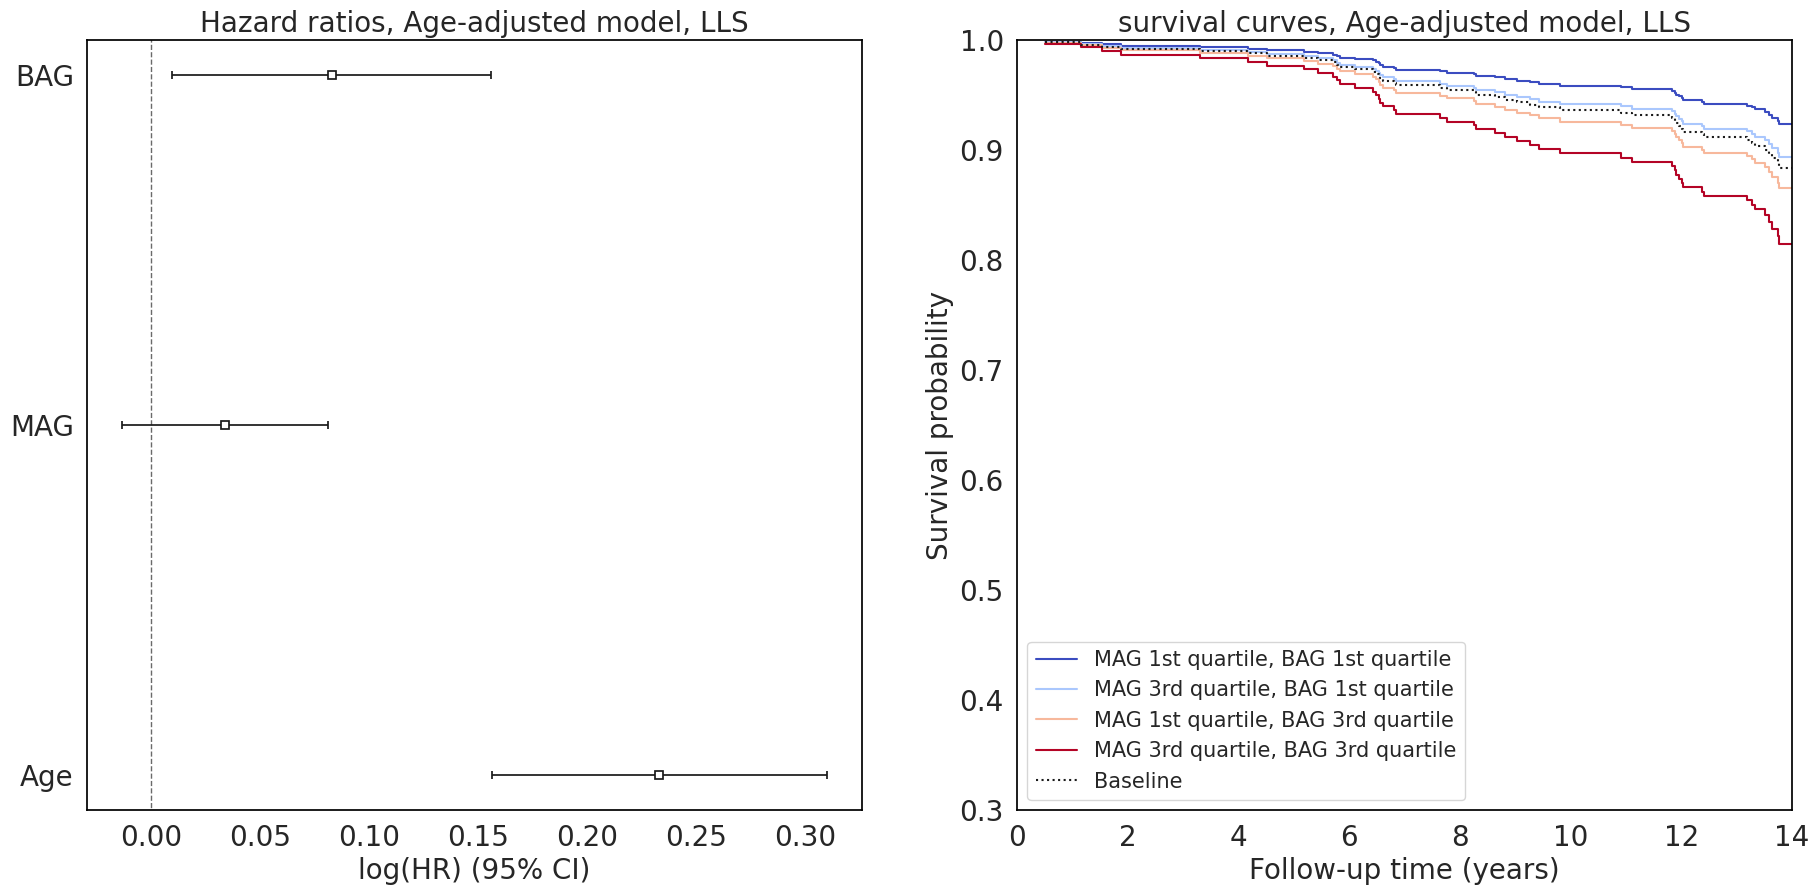

In [14]:
# make plot
fig, ax = plt.subplots(figsize = (22,10))

ax1=plt.subplot(121)
cox_ageOnly.plot(columns = ['BAG', 'MAG', 'Age'], ax=ax1)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=20)  # X-axis label
ax1.set_ylabel(ax1.get_ylabel(), fontsize=20)  # Y-axis label
ax1.tick_params(axis='both', which='major', labelsize=20)  # Tick labels
ax1.set_facecolor('white')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')

plt.title("Hazard ratios, Age-adjusted model, LLS",fontsize=20)


ax2=plt.subplot(122)


cox_ageOnly.plot_partial_effects_on_outcome(['MAG','BAG'], values=[
 [-4.2897232, -6.62039421],
 [5.84873482,  -6.62039421],
 [-4.2897232, 0.57884891],
 [5.84873482,  0.57884891]], cmap='coolwarm',ax=ax2, fontsize = 20)

ax2.set_xlabel('Follow-up time (years)', fontsize = 20)
ax2.set_ylabel('Survival probability', fontsize = 20)
ax2.set_facecolor('white')
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')

handles, labels = ax2.get_legend_handles_labels()
labels = ['MAG 1st quartile, BAG 1st quartile', 'MAG 3rd quartile, BAG 1st quartile', 'MAG 1st quartile, BAG 3rd quartile','MAG 3rd quartile, BAG 3rd quartile', 'Baseline'] 
# ax.legend(handles, labels, fontsize=20)
ax2.legend(handles, labels,fontsize=15,facecolor='white')
plt.ylim([0.3, 1])
plt.xlim([0, 14])
plt.title("survival curves, Age-adjusted model, LLS", fontsize = 20)




# 3. Including all variables
## Predict dementia

In [15]:
coxph = CoxPHFitter()
surv_df['Education'] = surv_df['education_category']
surv_df['DM'] = surv_df['Diabetes diagnosis'] = surv_df['Diabetes_Mellitus']
cox_allCov = coxph.fit(surv_df[['event_time_years', 'mort', 'Age', "Sex", "DM", "BMI","Education",  'BAG', 'MAG']], 'event_time_years', 'mort')
cox_allCov.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
Age,0.216569,0.039960,5.969850e-08
Sex,-0.688462,0.326589,3.502763e-02
DM,0.486419,0.486324,3.172159e-01
BMI,0.049712,0.041374,2.295473e-01
Education,0.044248,0.161272,7.838022e-01
BAG,0.071697,0.040779,7.871960e-02
MAG,0.028724,0.023104,2.137827e-01


In [16]:
print(np.quantile(surv_df['delta_ma'],[0.25,0.75]))
print(np.quantile(surv_df['delta_ba'],[0.25,0.75]))


[-4.2897232   5.84873482]
[-6.62039421  0.57884891]


/tmp/ipykernel_156128/3825978137.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1=plt.subplot(121)


Text(0.5, 1.0, 'survival curves, All-covariates-adjusted model, LLS')

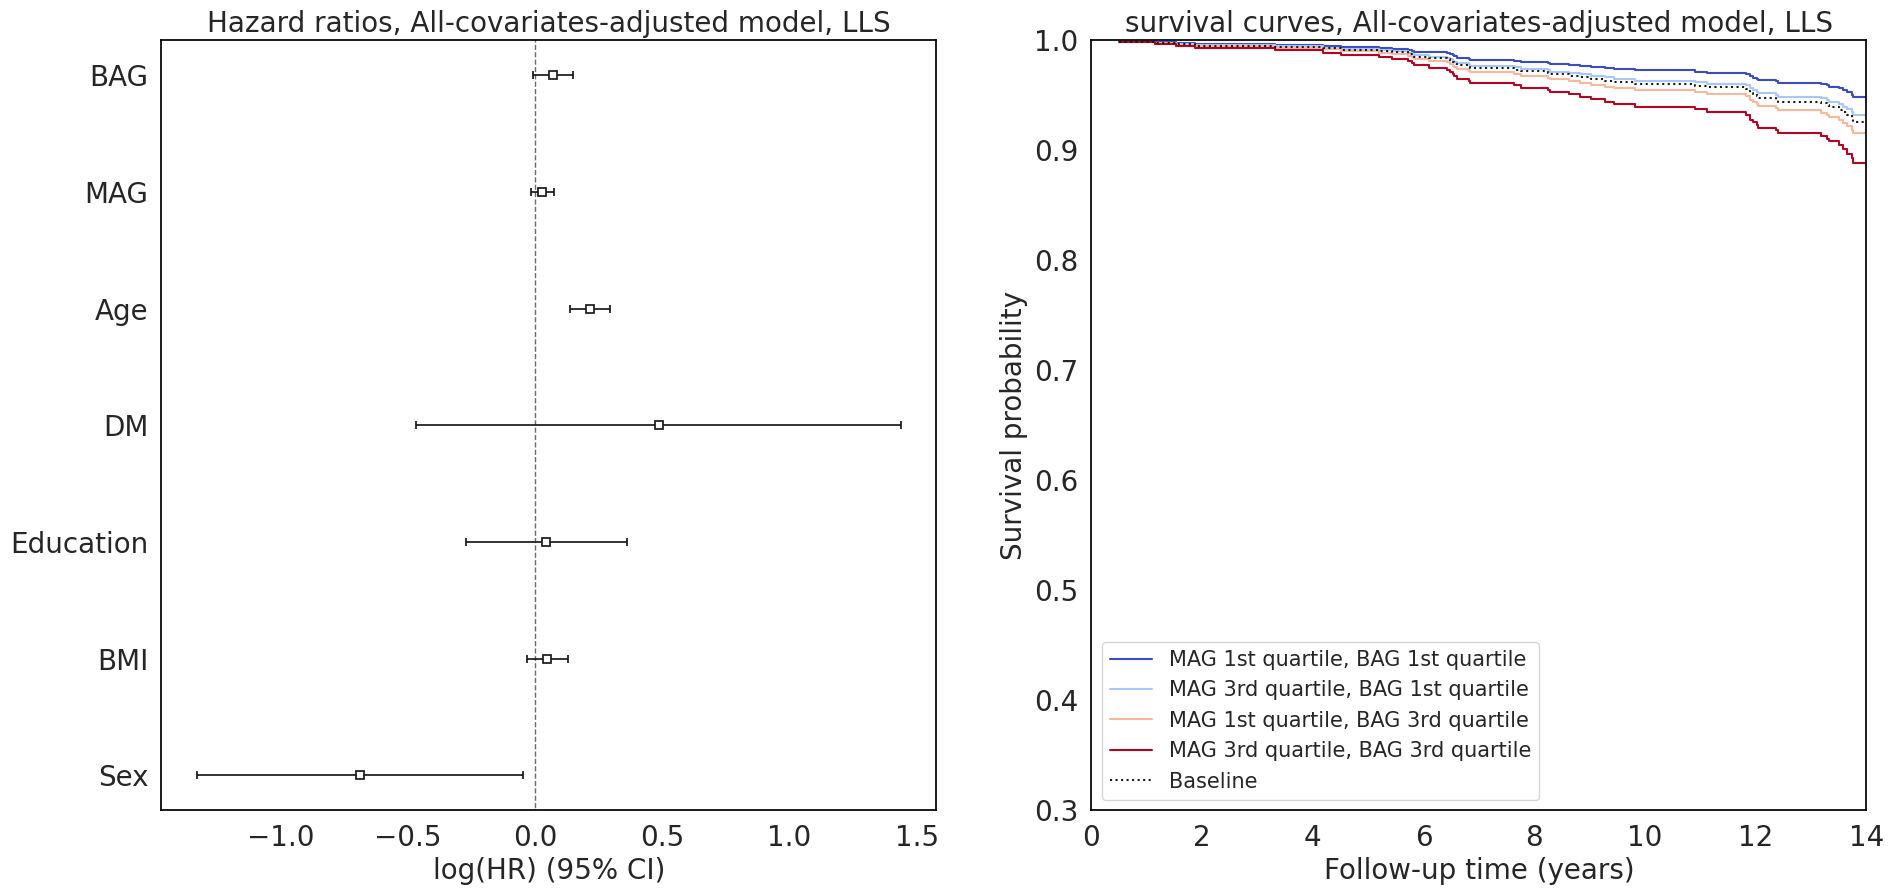

In [17]:

fig, ax = plt.subplots(figsize = (22,10))

ax1=plt.subplot(121)
cox_allCov.plot(ax=ax1, columns = [ 'BAG', 'MAG','Age', "DM", "Education", "BMI","Sex" ])
ax1.set_xlabel(ax1.get_xlabel(), fontsize=20)  # X-axis label
ax1.set_ylabel(ax1.get_ylabel(), fontsize=20)  # Y-axis label
ax1.tick_params(axis='both', which='major', labelsize=20)  # Tick labels
ax1.set_facecolor('white')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')

plt.title("Hazard ratios, All-covariates-adjusted model, LLS",fontsize=20)


ax2=plt.subplot(122)


cox_allCov.plot_partial_effects_on_outcome(['MAG','BAG'], values=[
 [-4.2897232, -6.62039421],
 [5.84873482,  -6.62039421],
 [-4.2897232, 0.57884891],
 [5.84873482,  0.57884891]], cmap='coolwarm',ax=ax2, fontsize = 20)

ax2.set_xlabel('Follow-up time (years)', fontsize = 20)
ax2.set_ylabel('Survival probability', fontsize = 20)
ax2.set_facecolor('white')
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')

handles, labels = ax2.get_legend_handles_labels()
labels = ['MAG 1st quartile, BAG 1st quartile', 'MAG 3rd quartile, BAG 1st quartile', 'MAG 1st quartile, BAG 3rd quartile','MAG 3rd quartile, BAG 3rd quartile', 'Baseline'] 
# ax.legend(handles, labels, fontsize=20)
ax2.legend(handles, labels,fontsize=15,facecolor='white')
plt.ylim([0.3, 1])
plt.xlim([0, 14])
plt.title("survival curves, All-covariates-adjusted model, LLS", fontsize = 20)




## Same stuff, but for metaboHealth

In [ ]:
coxph = CoxPHFitter()
surv_df['\u0394 brainAge'] = surv_df['delta_ba']
# surv_df['\u0394 metaboAge'] = surv_df['delta_ma']
cox_ageOnly_MH = coxph.fit(surv_df[['event_time', 'mort', 'Age', '\u0394 brainAge', 'metabo_health']], 'event_time', 'mort')
cox_ageOnly_MH.summary[['coef', 'se(coef)', 'p']]

In [ ]:
cox_ageOnly_MH.plot()
plt.title("Hazard ratios for Age-adjusted model (MetaboHealth), LLS")

In [ ]:
print(np.quantile(surv_df['metabo_health'],[0.25,0.75]))
print(np.quantile(surv_df['delta_ba'],[0.25,0.75]))


In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

cox_ageOnly_MH.plot_partial_effects_on_outcome(['metabo_health','\u0394 brainAge'], values=[
 [-0.2368191, -6.62039421],
 [0.15179443,  -6.62039421],
 [-0.2368191, 0.57884891],
 [0.15179443,  0.57884891]], cmap='coolwarm',ax=ax)

ax.set_xlabel('Follow-up time (days)')
ax.set_ylabel('Survival probability')
handles, labels = ax.get_legend_handles_labels()
labels = ['MetaboHealth 1st quartile, \u0394BA 1st quartile', 'MetaboHealth 3rd quartile, \u0394BA 1st quartile', 'MetaboHealth 1st quartile, \u0394BA 3rd quartile','MetaboHealth 3rd quartile, \u0394BA 3rd quartile'] 
ax.legend(handles, labels)

plt.ylim([0.88, 1])
# plt.xlim([0, 5000])
plt.title("survival curves, age-adjusted, LLS")
plt.show()

In [ ]:
coxph_allCov_MH = CoxPHFitter()
surv_df['Education'] = surv_df['education_category']
surv_df['Diabetes diagnosis'] = surv_df['Diabetes_Mellitus']
cox_allCov = coxph_allCov_MH.fit(surv_df[['event_time', 'mort', 'Age', '\u0394 brainAge', 'metabo_health', "Sex", "BMI", "Diabetes diagnosis", "Education"]], 'event_time', 'mort')
cox_allCov.summary[['coef', 'se(coef)', 'p']]

In [ ]:
coxph_allCov_MH.plot()

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

coxph_allCov_MH.plot_partial_effects_on_outcome(['metabo_health','\u0394 brainAge'], values=[
 [-0.2368191, -6.62039421],
 [0.15179443,  -6.62039421],
 [-0.2368191, 0.57884891],
 [0.15179443,  0.57884891]], cmap='coolwarm',ax=ax)

ax.set_xlabel('Follow-up time (days)')
ax.set_ylabel('Survival probability')
handles, labels = ax.get_legend_handles_labels()
labels = ['MetaboHealth 1st quartile, \u0394BA 1st quartile', 'MetaboHealth 3rd quartile, \u0394BA 1st quartile', 'MetaboHealth 1st quartile, \u0394BA 3rd quartile','MetaboHealth 3rd quartile, \u0394BA 3rd quartile'] 
ax.legend(handles, labels)
plt.title("survival curves, adjusted for all covariates, MetaboHealth, LLS")
plt.ylim([0.88, 1])

plt.show()